# Introduction
In this project we are going to analyze 'Brain tumor dataset', a T1 weighted MRI dataset from figshare,
<br>
apply preprocessing functions and create image classification model based on two Convolutional neural network models that predicts both brain tumor type and it's location.
<br><br>
**Contents:**
1) **Data exploration**
    <br>
    1.1 - Image extraction <br>
    1.2 - Splitting Data <br>
    1.3 - Preview images <br>
    1.4 - Black/White balance <br>
    1.5 - Skull size <br>
    1.6 - Class weights <br>
    1.7 - Feature scaling <br><br>
2) **1st Model (tumor type)**
    <br>
    2.1 - Building a model <br>
    2.2 - Visualising results <br>
    2.3 - Testing the model <br><br>
3) **Predicting tumor location**
    <br>
    3.1 - Mask extraction <br>
    3.2 - Splitting Data <br>
    3.3 - Preview the masks <br>
    3.4 - Tumor size <br>
    3.5 - Feature scaling <br><br>
4) **2nd Model (tumor location)**
5) **Conclusion**
<br>

Highly reccomended to read the **data-description.txt** file to understand data organization.

# I Data exploration
#### 1.1 - Image extraction
The Dataset is in .mat format, so we extract the image values to regular image files.
<br>
For this task we're going to use h2py and cv2 libraries and iterate through mat dataset.
<br><br>
*We don't really need to do that, but I want to show the process as working with regular images.
<br>
Technically we supposed to to assign labels to integer values because later on we'll use loss='sparse_categorical_crossentropy' which is prepared for said value type.

In [252]:
import tensorflow as tf
import numpy as np
import os

# apply stable seed to avoid inconsistent results every time we test new setup
tf.config.experimental.enable_op_determinism()
tf.keras.utils.set_random_seed(0)
tf.random.set_seed(0)
np.random.seed(0)

# define paths for datasets
mat_path = 'D:\\data-science\\brain-tumor-data\\mat'
data_path = 'D:\\data-science\\brain-tumor-data\\images'
data_path_split = data_path + '_split'
mask_path = 'D:\\data-science\\brain-tumor-data\\mask'

matrices = os.listdir(mat_path)

In [2]:
import matplotlib.pyplot as plt

# DON'T MIND THIS, it's dark theme for matplotlib
WHITE_MID = '#b5b5b5'
GREY_DARK = '#141414'

plt.rcParams['figure.facecolor'] = GREY_DARK
plt.rcParams['text.color'] = WHITE_MID
plt.rcParams['axes.facecolor'] = GREY_DARK
plt.rcParams['axes.edgecolor'] = WHITE_MID
plt.rcParams['axes.labelcolor'] = WHITE_MID
plt.rcParams['axes.titlecolor'] = WHITE_MID

plt.rcParams['grid.color'] = WHITE_MID
plt.rcParams['grid.linestyle'] = '--'
plt.rcParams['grid.linewidth'] = 0.5
plt.rcParams['axes.grid'] = True

plt.rcParams['axes.linewidth'] = 1
plt.rcParams['xtick.color'] = WHITE_MID
plt.rcParams['ytick.color'] = WHITE_MID
plt.rcParams['legend.edgecolor'] = WHITE_MID
plt.rcParams['legend.labelcolor'] = WHITE_MID

In [3]:
from skimage import exposure
import cv2 as cv
import h5py

label_names = {1: 'meningioma',
               2: 'glioma',
               3: 'pituitary'}

# this iteration generates .png files in data_path directory
for i, mat in enumerate(matrices):
    break

    # reads the .mat files from mat data path
    with h5py.File(f"{mat_path}\\{mat}", 'r') as file:
        image = file['cjdata']['image']
        label = int(file['cjdata']['label'][0])

        # normalize values by maximum where [min, max] = [0, 1]
        image = np.array(image) / np.max(image)
        image *= 255

        # taking off 'near black' values to reduce background noise
        # image[image <= 0.05] = 0
        # image *= 255

        # apply contrast stretching
        # image = exposure.rescale_intensity(image)
        # image *= 255

        # increase exposure
        # image = exposure.equalize_hist(image)

        image = np.array(image).astype(np.uint8)

        # save the results to new data path
        cv.imwrite(os.path.join(data_path, label_names[label], f"{label_names[label]}_{i}.png"), image)
    # print(f"\r{int((i + 1) / 3064)} %", end='', flus=True)
print('Done!')

Done!


#### 1.2 - Splitting data
For this task we use _splitfolders_ library. This makes us sure that data is correctly split without any leaks.
<br><br>
**Ratio:** <br>
train: 70% <br>
val: 20% <br>
test: 10%

In [6]:
import splitfolders

splitfolders.ratio(input=data_path, output=data_path_split, ratio=(.7, .2, .1), seed=0)

Copying files: 3064 files [00:02, 1177.17 files/s]


In [3]:
train = tf.keras.utils.image_dataset_from_directory(os.path.join(data_path_split, 'train'), batch_size=8, color_mode='grayscale', image_size=(256, 256))
test = tf.keras.utils.image_dataset_from_directory(os.path.join(data_path_split, 'test'), batch_size=8, color_mode='grayscale', image_size=(256, 256))
val = tf.keras.utils.image_dataset_from_directory(os.path.join(data_path_split, 'val'), batch_size=8, color_mode='grayscale', image_size=(256, 256))

data_iterator = test.as_numpy_iterator()
batch = data_iterator.next()

labels = test.class_names
labels

Found 2144 files belonging to 3 classes.
Found 308 files belonging to 3 classes.
Found 612 files belonging to 3 classes.


['glioma', 'meningioma', 'pituitary']

To ensure that there are no leaks that might overfit our model learning process or lead to false accuracy results during testing
<br>
I applied simple iterations that takes every image from one split and compares it with each image from another split.

In [8]:
# take all images per dataset split into one array for better iteration
train_images = np.concatenate([img.numpy() for img, label in train], axis=0)
val_images = np.concatenate([img.numpy() for img, label in val], axis=0)
test_images = np.concatenate([img.numpy() for img, label in test], axis=0)

count = 0
for train_img in train_images:
    # break
    if any(np.array_equal(train_img, val_img) for val_img in val_images):
        count += 1
print(f"There are {count} data leaks between train and val splits.")

count = 0
for train_img in train_images:
    # break
    if any(np.array_equal(train_img, test_img) for test_img in test_images):
        count += 1
print(f"There are {count} data leaks between train and test splits.")

count = 0
for val_img in val_images:
    # break
    if any(np.array_equal(val_img, test_img) for test_img in test_images):
        count += 1
print(f"There are {count} data leaks between val and test splits.")

There are 0 data leaks between train and val splits.
There are 0 data leaks between train and test splits.
There are 0 data leaks between val and test splits.


#### 1.3 - Preview the images
Data iterator allows us to move through data and preview it more swiftly.

   batches: 8
     width: 256
    height: 256
  channels: 1


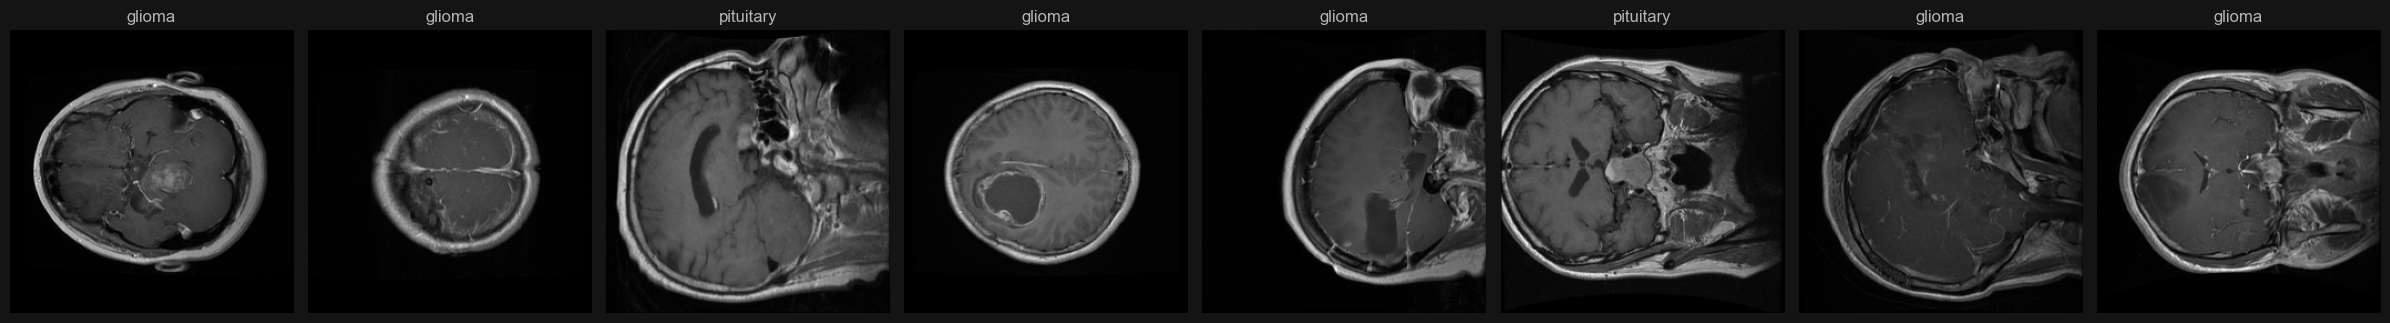

In [4]:
import seaborn as sb

fig, axes = plt.subplots(nrows=1, ncols=8, figsize=(24, 6))
for i, img in enumerate(batch[0][:8]):
    class_name = labels[batch[1][i]]
    axes[i].imshow(img, cmap='gray')
    axes[i].set_title(class_name)
    axes[i].set_axis_off()

for key, value in zip(['batches', 'width', 'height', 'channels'], batch[0].shape):
    print(f"{key:>10}: {value}")

plt.tight_layout()
plt.show()

Our dataset contains 512px x 512px images and each pixel has 3 channels so basically each image contains **786 432** values,
<br>
with *color_mode = 'grayscale'* we reduce it to **262 144**. Also keras resized our files to size of 256px x 256px so we end up with **65 536** values per image.

#### 1.4 - Black/white balance
Every point on the plot is a single image, we can note that most of images hang around 45.

In [5]:
from scipy.stats.mstats import hmean

# skipping value 0 because it's background and it will lower our mean
all_means = [x[x != 0].mean() for x in train_images]

print(f'{'Mean':>14}: {np.mean(all_means)}\n'
      f'{'Harmonic mean':>14}: {hmean(all_means)}')

fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(20, 10))
sb.scatterplot(y=[x for x in range(len(all_means))], x=all_means, color=WHITE_MID, s=20, ax=axes[0], marker='.', linewidth=0)
sb.kdeplot(x=all_means, ax=axes[1], color=WHITE_MID)

padding = (min(all_means) - 5, max(all_means) + 5)
axes[0].set_xlim(padding)
axes[0].set_title('All images')
axes[1].set_xlim(padding)
axes[1].set_title('Density')
plt.tight_layout()

NameError: name 'train_images' is not defined

#### 1.5 Skull size
By calculating amount of black pixels inside image we can extract images with specific skull/head size.
<br>
__*threshold*__ is max value that we consider/define as black background. The more the noisy our background is the higher the threshold we apply.
<br>
<br>
In summary this plot returns images where background fills specified % (see percentage variable) of area.
<br>


In [6]:
threshold = 10
percentage = 75

all_images = np.concatenate([train_images, val_images, test_images], axis=0)
dataset_black_pixels =[]

fig, axes = plt.subplots(nrows=3, ncols=6, figsize=(24, 12))
axes = axes.flatten()

small_skull = 0
i = 0
for img in all_images:
    n_black_pixels = np.sum(img <= threshold)
    percentage_black_pixels = (n_black_pixels / (256*256)) * 100
    dataset_black_pixels.append(percentage_black_pixels)
    
    if percentage_black_pixels > percentage:
        if i < 18:
            small_skull += 1
            axes[i].set_title(f"black pixels: {round(percentage_black_pixels, 2)} %")
            axes[i].set_axis_off()
            axes[i].imshow(img, cmap='gray')
            i += 1

print(f"There are {small_skull} image/s with background filling more than {percentage}%")
plt.tight_layout()

NameError: name 'train_images' is not defined

I suppose these are newborns but last image looks like top of the skull. <br>
Note that the photos are from a single dataset, <br>
so it is very likely that the photos have not been previously scaled, and the brains do not appear to be developed.
<br><br>
This allow us to categorize images based on skull size.

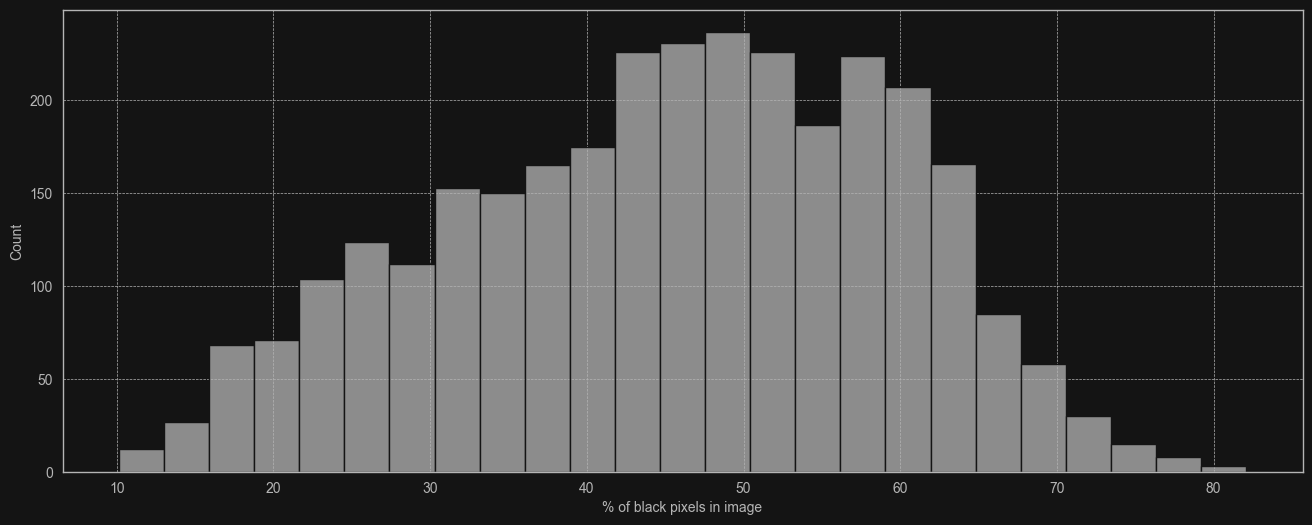

In [17]:
plt.figure(figsize=(16, 6))

sb.histplot(data=dataset_black_pixels, color=WHITE_MID, linewidth=1, edgecolor=GREY_DARK)
plt.xlabel('% of black pixels in image')
plt.show()

#### 1.6 - Class weights

Class        Count
glioma     : 1426
meningioma : 708
pituitary  : 930


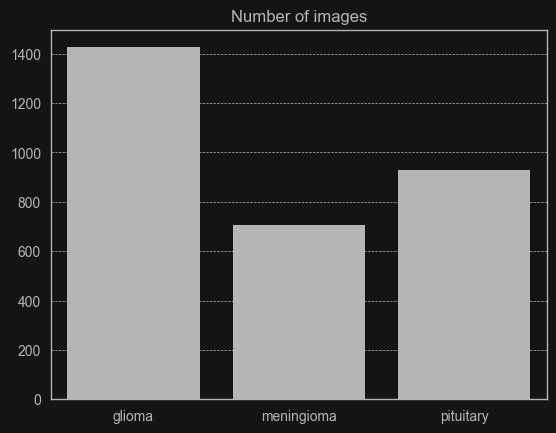

In [7]:
files_per_label = lambda folder: os.listdir(os.path.join(data_path, folder))

# generate dictionary with lengths for each label
labels_len = {label: len(files_per_label(label)) for i, label in enumerate(labels)}

sb.barplot(data=labels_len, x=labels_len.keys(), y=labels_len.values(), color=WHITE_MID, linewidth=0)

print(f"{'Class':<10}   Count")
for label, count in labels_len.items():
    print(f"{label:<10} : {count}")

plt.title('Number of images')
plt.show()

**To handle class imbalance, we can calculate weights with given formula:**
<br><br>
$w_c = \frac{N}{N_c * C}$
<br><br>
where:
<br>
$ w_c $ = class weight <br>
$ N $ = number of samples in dataset <br>
$ N_c $ = number of samples in class <br>
$ C $ = number of unique classes in dataset

In [8]:
class_weights = dict()

for i, count in enumerate(labels_len.values()):
    class_weights[i] = sum(labels_len.values()) / (len(labels) * count)

print(f"{'Class':<10}   Weight")
for i, weight in class_weights.items():
    print(f"{labels[i]:<10} : {weight}")

Class        Weight
glioma     : 0.7162225338943432
meningioma : 1.4425612052730696
pituitary  : 1.0982078853046595


#### 1.7 - Feature scaling
Usually when we work with Images, the max value is 255 so we're going to transform our values from [min, max] = [0, 255] to [0, 1].

In [9]:
print(batch[0].min(), batch[0].max(), sep='\n')

0.0
253.5


In [10]:
train = train.map(lambda x, y: (x/255, y))
test = test.map(lambda x, y: (x/255, y))
val = val.map(lambda x, y: (x/255, y))

iterator = test.as_numpy_iterator()
batch = iterator.next()

min_value = iterator.next()[0].min()
max_value = iterator.next()[0].max()

print(min_value, max_value, sep='\n')

0.0
0.96666664


# II 1st Model
#### 2.1 - Building a neural network
In short our model base on convolutional layers, where each layer contain filter that convolve with input matrix (image) resulting filtered output.
<br>
As input shape we apply values that corresponds to:
- width = 256
- height = 256
- channel = 1 (grayscale).
<br>

__*ReLU*__ activation function cleans our output from all unnecessary negative values, replacing them with zeros.
<br>
__*Dropout*__ layers drops random neurons each time convolution layer is being applied, reducing chance to overfit.
<br>
Since our dataset contain 3 classes I applied __*softmax*__ activation to the last step.

In [11]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout, Input, ReLU
from tensorflow.keras.regularizers import l1, l2, l1_l2
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

In [12]:
def create_model(num_filters=16, kernel_size=3, learning_rate=0, regulate=0, slope=0):
    
    model = Sequential()
    
    model.add(Input(shape=(256, 256, 1)))
    
    model.add(Conv2D(num_filters, (kernel_size, kernel_size), 1, activation='relu'))
    model.add(Dropout(0.3))
    model.add(MaxPooling2D())
    
    model.add(Conv2D(num_filters * 2, (kernel_size, kernel_size), 1, activation='relu'))
    model.add(Dropout(0.3))
    model.add(MaxPooling2D())
    
    model.add(Conv2D(num_filters, (kernel_size, kernel_size), 1, activation='relu'))
    model.add(Dropout(0.3))
    model.add(MaxPooling2D())
    
    model.add(Flatten())
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(3, activation='softmax'))
    
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='sparse_categorical_crossentropy', metrics=['sparse_categorical_accuracy'])
    
    return model

In [13]:
model = create_model(learning_rate=0.0005)
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 254, 254, 16)   │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 254, 254, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 127, 127, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 125, 125, 32)   │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 125, 125, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 62, 62, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 60, 60, 16)     │         4,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 60, 60, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 30, 30, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 14400)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     3,686,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │           771 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,696,851 (14.10 MB)

 Trainable params: 3,696,851 (14.10 MB)

 Non-trainable params: 0 (0.00 B)

In [14]:
n_epochs = 20

early_stopping = EarlyStopping(
    monitor='val_loss',
    restore_best_weights=True,
    baseline=None,
    min_delta=0,
    patience=n_epochs,
    verbose=0,
)

In [96]:
hist = model.fit(train, validation_data=val, epochs=n_epochs, class_weight=class_weights, verbose=2, callbacks=[early_stopping])

Epoch 1/20
268/268 - 27s - 102ms/step - loss: 0.6682 - sparse_categorical_accuracy: 0.6637 - val_loss: 0.6406 - val_sparse_categorical_accuracy: 0.7337
Epoch 2/20
268/268 - 25s - 92ms/step - loss: 0.4556 - sparse_categorical_accuracy: 0.8018 - val_loss: 0.5746 - val_sparse_categorical_accuracy: 0.7304
Epoch 3/20
268/268 - 25s - 92ms/step - loss: 0.3292 - sparse_categorical_accuracy: 0.8554 - val_loss: 0.4751 - val_sparse_categorical_accuracy: 0.7712
Epoch 4/20
268/268 - 25s - 91ms/step - loss: 0.2172 - sparse_categorical_accuracy: 0.9086 - val_loss: 0.4267 - val_sparse_categorical_accuracy: 0.7941
Epoch 5/20
268/268 - 25s - 93ms/step - loss: 0.1726 - sparse_categorical_accuracy: 0.9296 - val_loss: 0.3975 - val_sparse_categorical_accuracy: 0.8072
Epoch 6/20
268/268 - 28s - 106ms/step - loss: 0.1231 - sparse_categorical_accuracy: 0.9515 - val_loss: 0.3416 - val_sparse_categorical_accuracy: 0.8366
Epoch 7/20
268/268 - 25s - 93ms/step - loss: 0.0915 - sparse_categorical_accuracy: 0.9669 - 

#### 2.2 - Visualising results

      val loss: 0.1830584704875946
  val accuracy: 0.9411764740943909


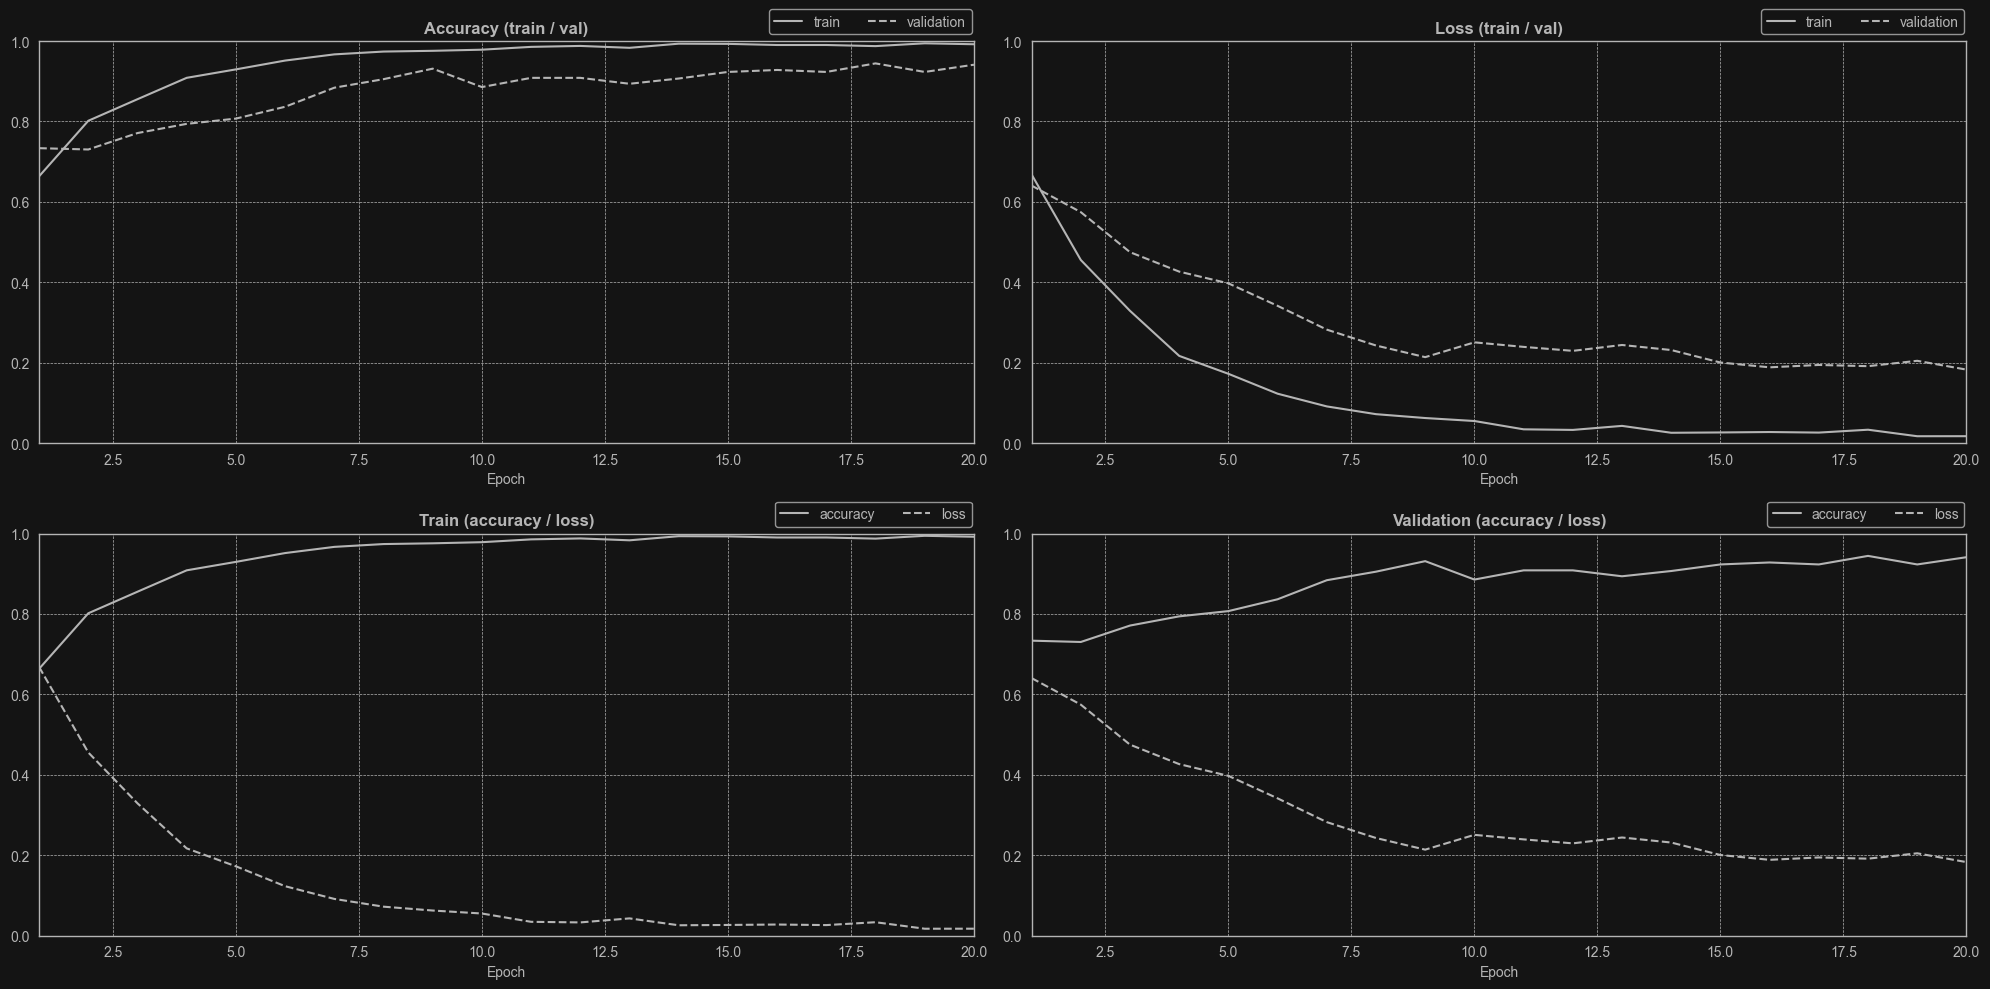

In [121]:
acc_labels = list(hist.history.keys())

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(20, 10))
axes = axes.flatten()

sb.lineplot(data=hist.history, y='sparse_categorical_accuracy', x=[x for x in range(1, n_epochs+1, 1)], label='train', ax=axes[0], color=WHITE_MID)
sb.lineplot(data=hist.history, y='val_sparse_categorical_accuracy', x=[x for x in range(1, n_epochs+1, 1)], label='validation', ax=axes[0], linestyle='--', color=WHITE_MID)

sb.lineplot(data=hist.history, y='loss', x=[x for x in range(1, n_epochs+1, 1)], label='train', ax=axes[1], color=WHITE_MID)
sb.lineplot(data=hist.history, y='val_loss', x=[x for x in range(1, n_epochs+1, 1)], label='validation', ax=axes[1], linestyle='--', color=WHITE_MID)

sb.lineplot(data=hist.history, y='sparse_categorical_accuracy', x=[x for x in range(1, n_epochs+1, 1)], label='accuracy', ax=axes[2], color=WHITE_MID)
sb.lineplot(data=hist.history, y='loss', x=[x for x in range(1, n_epochs+1, 1)], label='loss', ax=axes[2], linestyle='--', color=WHITE_MID)

sb.lineplot(data=hist.history, y='val_sparse_categorical_accuracy', x=[x for x in range(1, n_epochs+1, 1)], label='accuracy', ax=axes[3], color=WHITE_MID)
sb.lineplot(data=hist.history, y='val_loss', x=[x for x in range(1, n_epochs+1, 1)], label='loss', ax=axes[3], linestyle='--', color=WHITE_MID)

for i in range(4):
    axes[i].legend(loc='lower right', bbox_to_anchor=(1.005, 1), ncol=2)
    axes[i].set_xlabel('Epoch')
    axes[i].set_ylim([0, 1])
    axes[i].set_xlim([1, n_epochs])
    axes[i].set_ylabel('')

axes[0].set_title('Accuracy (train / val)', weight='bold')
axes[1].set_title('Loss (train / val)', weight='bold')
axes[2].set_title('Train (accuracy / loss)', weight='bold')
axes[3].set_title('Validation (accuracy / loss)', weight='bold')

final_metrics = model.evaluate(val, verbose=0)
for key, value in zip(['val loss', 'val accuracy'], final_metrics):
    print(f"{key:>14}: {value}")

plt.tight_layout()

#### 2.3 - Testing the model
Both Training and Validation curves looks very promising, however we have to test our model for final results.

In [98]:
y_true = []
y_pred = []

for batch_images, batch_labels in test:
    y_true_batch = batch_labels
    y_pred_batch = np.argmax(model.predict(batch_images, verbose=0), axis=1)

    y_true.extend(y_true_batch)
    y_pred.extend(y_pred_batch)
    
y_true = np.array(y_true)
y_pred = np.array(y_pred)

              precision    recall  f1-score   support

      glioma       0.97      0.98      0.97       143
  meningioma       0.95      0.86      0.91        72
   pituitary       0.94      0.99      0.96        93

    accuracy                           0.95       308
   macro avg       0.95      0.94      0.95       308
weighted avg       0.95      0.95      0.95       308



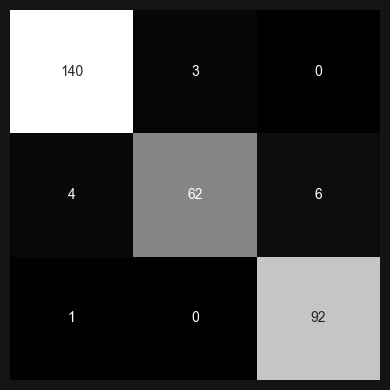

In [120]:
from sklearn.metrics import classification_report, confusion_matrix

report = classification_report(y_true, y_pred, target_names=labels)
print(report)

cm = confusion_matrix(y_true=y_true, y_pred=y_pred)
fig = plt.figure(figsize=(4, 4))
fig = sb.heatmap(cm, annot=True, fmt='d', cbar=False, cmap='Greys_r', linewidths=0)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.axis('off')
plt.tight_layout()

# III Finding tumor location
#### 3.1 - Mask extraction
Because it's different task. I've split the dataset to another 2 folders: 'x-images' and 'y-masks'.

In [254]:
path_to_images = os.path.join(mask_path, 'x-image')
path_to_masks = os.path.join(mask_path, 'y-mask')
print(path_to_images, path_to_masks, sep='\n')

D:\data-science\brain-tumor-data\mask\x-image
D:\data-science\brain-tumor-data\mask\y-mask


In [255]:
from skimage import exposure
import cv2 as cv
import h5py

label_names = {1: 'meningioma',
               2: 'glioma',
               3: 'pituitary'}

# this iteration generates .png files in data_path directory
for i, mat in enumerate(matrices):
    break

    # reads the .mat files from mat data path
    with h5py.File(f"{mat_path}\\{mat}", 'r') as file:
        image = file['cjdata']['image']
        label = int(file['cjdata']['label'][0])
        tumor_border = file['cjdata']['tumorBorder'][0]

        width, height = image.shape

        # the coordinates been saved with format: [x1 y1 x2 y2 x3 y3 ...]
        # also x, y coordinates in .mat files are flipped, so we assign x_coords to y and vice versa
        x_coords = [x for x in tumor_border[0::2]]
        y_coords = [y for y in tumor_border[1::2]]
        points = np.array([list(zip(y_coords, x_coords))], dtype=np.int32)

        # create blank matrix with size of original image
        # cv.fillPoly fills our blank matrix with 1s by taking positions from 'points'
        binary_mask = np.zeros((width, height), dtype=np.uint8)
        cv.fillPoly(binary_mask, points, 1)

        # normalize values by maximum where [min, max] = [0, 1]
        image = np.array(image) / np.max(image)
        image *= 255
        image = np.array(image).astype(np.uint8)

        binary_mask *= 255
        binary_mask = np.array(binary_mask).astype(np.uint8)

        # save the results to new data paths, had to fill the id with zeros to avoid incorrect files pairing
        cv.imwrite(os.path.join(path_to_images, f"{str(i+1).zfill(4)}.png"), image)
        cv.imwrite(os.path.join(path_to_masks, 'y-mask',f"{str(i+1).zfill(4)}_mask.png"), binary_mask)
print('Done!')

Done!


In [256]:
input_img_paths = sorted(
    [
        os.path.join(path_to_images, fname)
        for fname in os.listdir(path_to_images)
        if fname.endswith(".png")
    ]
)
mask_img_paths = sorted(
    [
        os.path.join(path_to_masks, fname)
        for fname in os.listdir(path_to_masks)
        if fname.endswith(".png") and not fname.startswith(".")
    ]
)

Checking name pairing.

In [257]:
import random
random.Random(0).shuffle(input_img_paths)
random.Random(0).shuffle(mask_img_paths)

In [258]:
count = 0
for nth_img_path, nth_mask_path in zip(input_img_paths, mask_img_paths):
    img_id = os.path.basename(nth_img_path)[:4]
    mask_id = os.path.basename(nth_mask_path)[:4]
    if img_id != mask_id:
        count += 1

print(f"Misaligned file names: {count}")
len(input_img_paths) == len(mask_img_paths)

Misaligned file names: 0


True

In [259]:
def get_dataset(
        batch_size,
        img_size,
        X_files,
        y_files,
):
    """Returns a TF Dataset."""

    def load_img_masks(nth_img_path, nth_mask_path):
        input_img = tf.io.read_file(nth_img_path)
        input_img = tf.io.decode_png(input_img, channels=1)
        input_img = tf.image.resize(input_img, img_size)
        input_img = tf.image.convert_image_dtype(input_img, "float32")

        mask_img = tf.io.read_file(nth_mask_path)
        mask_img = tf.io.decode_png(mask_img, channels=1)
        mask_img = tf.image.resize(mask_img, img_size, method="nearest")
        mask_img = tf.image.convert_image_dtype(mask_img, "uint8")

        return input_img, mask_img
    
    dataset = tf.data.Dataset.from_tensor_slices((X_files, y_files))
    dataset = dataset.map(load_img_masks, num_parallel_calls=tf.data.AUTOTUNE)
    return dataset.batch(batch_size)

In [260]:
train_nsamples = round((3064 * 0.7))
val_nsamples = round((3064 * 0.2))
test_nsamples = round((3064 * 0.1))
print(train_nsamples, val_nsamples, test_nsamples)
sum([train_nsamples, val_nsamples, test_nsamples]) == len(input_img_paths)

2145 613 306


True

#### 3.2 Splitting Data

In [261]:
X_train_files = input_img_paths[:train_nsamples]
y_train_files = mask_img_paths[:train_nsamples]

X_val_files = input_img_paths[train_nsamples:(train_nsamples + val_samples)]
y_val_files = mask_img_paths[train_nsamples:(train_nsamples + val_samples)]

X_test_files = input_img_paths[-test_nsamples:]
y_test_files = mask_img_paths[-test_nsamples:]

train_dataset = get_dataset(
    8,
    (256, 256),
    X_train_files,
    y_train_files
)

val_dataset = get_dataset(
    8,
    (256, 256),
    X_val_files,
    y_val_files
)

test_dataset = get_dataset(
    8,
    (256, 256),
    X_test_files,
    y_test_files
)

In [262]:
# checks if the files inside split are unique (no duplicates)
train_files_ids = set(os.path.basename(x) for x in X_train_files)
print(len(train_files_ids) == train_nsamples)

val_files_ids = set(os.path.basename(x) for x in X_val_files)
print(len(val_files_ids) == val_nsamples)

test_files_ids = set(os.path.basename(x) for x in X_test_files)
print(len(test_files_ids) == test_nsamples)

# this should return 3x False for proving there's no leaks between splits
print(bool(train_files_ids.intersection(val_files_ids)))
print(bool(train_files_ids.intersection(test_files_ids)))
print(bool(test_files_ids.intersection(val_files_ids)))

True
True
True
False
False
False


#### 3.3 - Preview the masks

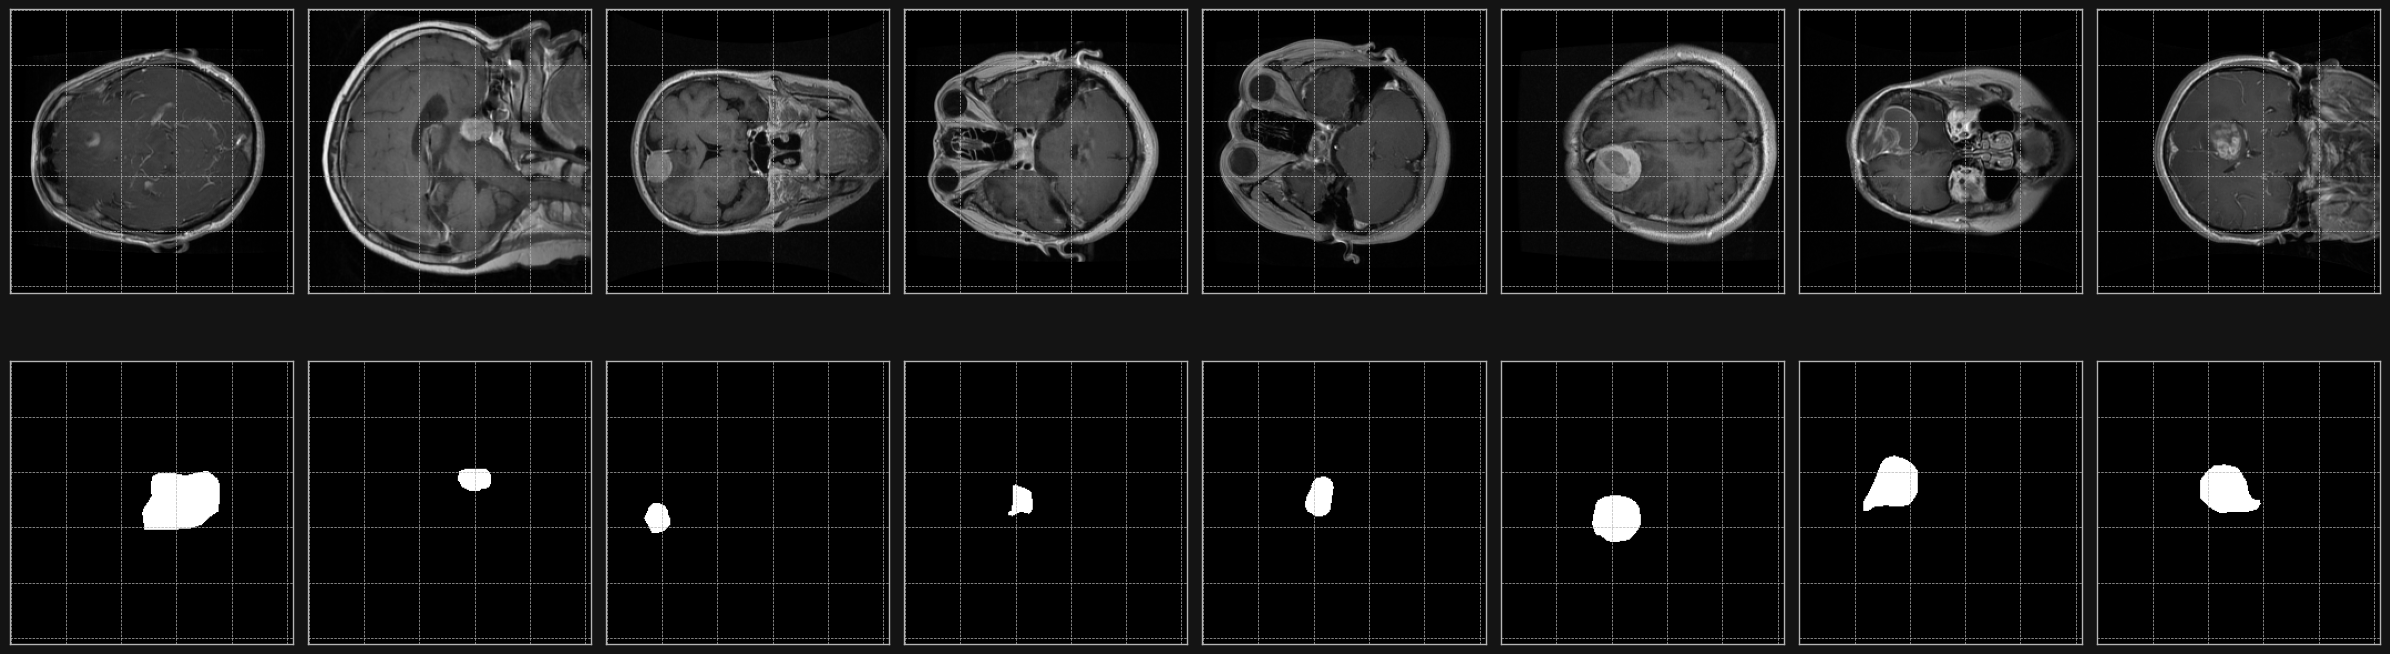

In [263]:
nth_batch = random.randint(0, 10)

fig, axes = plt.subplots(2, 8, figsize=(24, 8))
axes = axes.flatten()

for img, mask in test_dataset.take(nth_batch):
    for i in range(8):
        axes[i].imshow(img[i], cmap='grey')
        axes[i].set_xticklabels([])
        axes[i].set_yticklabels([])
        
        axes[i+8].imshow(mask[i], cmap='grey')
        axes[i+8].set_xticklabels([])
        axes[i+8].set_yticklabels([])

plt.tight_layout()

#### 3.4 Tumor size
This step is similar to skull size step. But this time we calculate the amount of WHITE pixels inside MASK images.

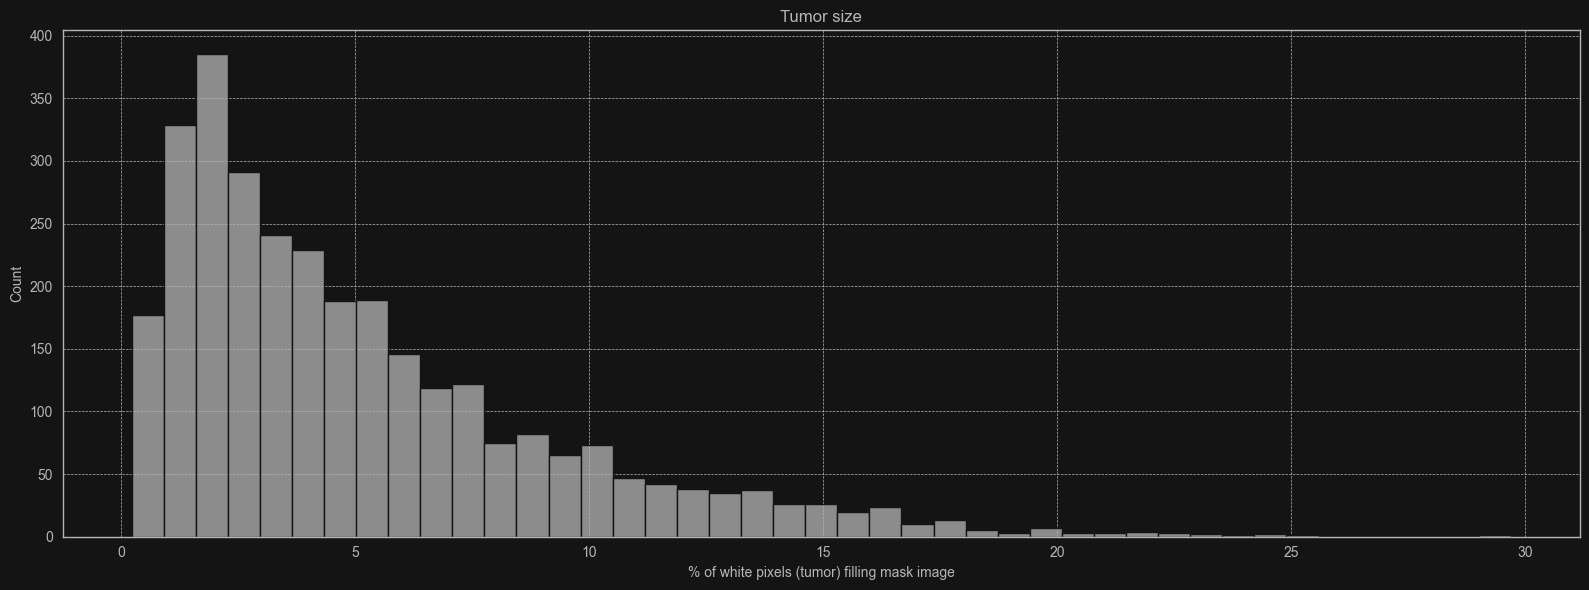

In [264]:
y_all = np.concatenate((y_train_files, y_val_files, y_test_files))
tumor_pixels = []

for nth_mask_path in y_all:
    mask = cv.imread(nth_mask_path)
    
    n_white_pixels = np.sum(mask == 255)
    percentage_white_pixels = (n_white_pixels / (512*512)) * 100
    tumor_pixels.append(percentage_white_pixels)

plt.figure(figsize=(16, 6))
sb.histplot(data=tumor_pixels, color=WHITE_MID, linewidth=1, edgecolor=GREY_DARK)
plt.title('Tumor size')
plt.xlabel('% of white pixels (tumor) filling mask image')
plt.tight_layout()

#### 3.5 - Feature scaling

In [380]:
batch_sample = train_dataset.take(1)

for img, mask in batch_sample:
    for i in range(8):
        print(f'batch img: {i}')
        print(
            f"min: {img[i].numpy().min()},",
            f"max: {img[i].numpy().max()}",
        )

batch img: 0
min: 0.0, max: 0.8460784554481506
batch img: 1
min: 0.0, max: 0.9882352948188782
batch img: 2
min: 0.0, max: 0.9637255072593689
batch img: 3
min: 0.0, max: 0.9392156600952148
batch img: 4
min: 0.0, max: 0.9823529124259949
batch img: 5
min: 0.0, max: 0.9372549057006836
batch img: 6
min: 0.0, max: 0.9813725352287292
batch img: 7
min: 0.0, max: 0.9852941036224365


In [266]:
train_dataset = train_dataset.map(lambda x, y: (x/255, y/255))
val_dataset = val_dataset.map(lambda x, y: (x/255, y/255))
test_dataset = test_dataset.map(lambda x, y: (x/255, y/255))

In [381]:
batch_sample = train_dataset.take(1)

for img, mask in batch_sample:
    for i in range(8):
        print(f'batch img: {i}')
        print(
            f"min: {img[i].numpy().min()},",
            f"max: {img[i].numpy().max()}",
        )

batch img: 0
min: 0.0, max: 0.8460784554481506
batch img: 1
min: 0.0, max: 0.9882352948188782
batch img: 2
min: 0.0, max: 0.9637255072593689
batch img: 3
min: 0.0, max: 0.9392156600952148
batch img: 4
min: 0.0, max: 0.9823529124259949
batch img: 5
min: 0.0, max: 0.9372549057006836
batch img: 6
min: 0.0, max: 0.9813725352287292
batch img: 7
min: 0.0, max: 0.9852941036224365


# IV 2nd Model
#### 4.1 - Building neural network
To predict mask we're going to use U-net CNN model.

In [286]:
from keras import layers

def create_unet_model(learning_rate=0.0001):

    # INPUT
    inputs = keras.Input(shape=(256, 256, 1))
    x = layers.Conv2D(16, 3, strides=2, padding="same")(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    # ENCODER
    for filters in [32, 64, 128]:
        x = layers.SeparableConv2D(filters, 3, padding="same", activation='relu')(x)
        x = layers.BatchNormalization()(x)

        x = layers.SeparableConv2D(filters, 3, padding="same", activation='relu')(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

    # DECODER
    for filters in [128, 64, 32, 16]:
        x = layers.Conv2DTranspose(filters, 3, padding="same", activation='relu')(x)
        x = layers.BatchNormalization()(x)

        x = layers.Conv2DTranspose(filters, 3, padding="same", activation='relu')(x)
        x = layers.BatchNormalization()(x)

        x = layers.UpSampling2D(2)(x)

    # Add a per-pixel classification layer
    outputs = layers.Conv2D(1, 3, activation="sigmoid", padding="same")(x)

    # define and compile
    model = keras.Model(inputs, outputs)
    model.compile(optimizer=keras.optimizers.Adam(learning_rate), loss="binary_crossentropy")
    return model

In [287]:
u_net = create_unet_model(learning_rate=0.0005)
u_net.summary()

Model: "functional_18"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_8 (InputLayer)      │ (None, 256, 256, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_43 (Conv2D)              │ (None, 128, 128, 16)   │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_90          │ (None, 128, 128, 16)   │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_62 (Activation)      │ (None, 128, 128, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ separable_conv2d_36             │ (None, 128, 128, 32)   │           688 │
│ (SeparableConv2D)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_91          │ (None, 128, 128, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ separable_conv2d_37             │ (None, 128, 128, 32)   │         1,344 │
│ (SeparableConv2D)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_92          │ (None, 128, 128, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_21 (MaxPooling2D) │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ separable_conv2d_38             │ (None, 64, 64, 64)     │         2,400 │
│ (SeparableConv2D)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_93          │ (None, 64, 64, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ separable_conv2d_39             │ (None, 64, 64, 64)     │         4,736 │
│ (SeparableConv2D)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_94          │ (None, 64, 64, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_22 (MaxPooling2D) │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ separable_conv2d_40             │ (None, 32, 32, 128)    │         8,896 │
│ (SeparableConv2D)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_95          │ (None, 32, 32, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ separable_conv2d_41             │ (None, 32, 32, 128)    │        17,664 │
│ (SeparableConv2D)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_96          │ (None, 32, 32, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 480,353 (1.83 MB)

 Trainable params: 478,465 (1.83 MB)

 Non-trainable params: 1,888 (7.38 KB)

In [288]:
n_epochs = 5

early_stopping = EarlyStopping(
    monitor='val_loss',
    restore_best_weights=True,
    baseline=None,
    min_delta=0,
    patience=n_epochs,
    verbose=0
)

In [289]:
hist_unet = u_net.fit(train_dataset, validation_data=val_dataset, epochs=n_epochs, callbacks=[early_stopping])

Epoch 1/5
269/269 ━━━━━━━━━━━━━━━━━━━━ 106s 354ms/step - loss: 0.5652 - val_loss: 0.1093
Epoch 2/5
269/269 ━━━━━━━━━━━━━━━━━━━━ 91s 336ms/step - loss: 0.0737 - val_loss: 0.0921
Epoch 3/5
269/269 ━━━━━━━━━━━━━━━━━━━━ 91s 336ms/step - loss: 0.0409 - val_loss: 0.0498
Epoch 4/5
269/269 ━━━━━━━━━━━━━━━━━━━━ 90s 333ms/step - loss: 0.0326 - val_loss: 0.0531
Epoch 5/5
269/269 ━━━━━━━━━━━━━━━━━━━━ 90s 334ms/step - loss: 0.0275 - val_loss: 0.0391


#### 4.2 - Testing the U-Net model

In [371]:
y_true = []
y_pred = []
x_true = []

for image_batch, mask_batch in test_dataset:
    y_true_batch = mask_batch
    y_pred_batch = u_net.predict(image_batch, verbose=0)
    
    y_true.extend(y_true_batch)
    y_pred.extend(y_pred_batch)
    x_true.extend(image_batch)
    
y_true = np.array(y_true)
y_pred = np.array(y_pred)
x_true = np.array(x_true)

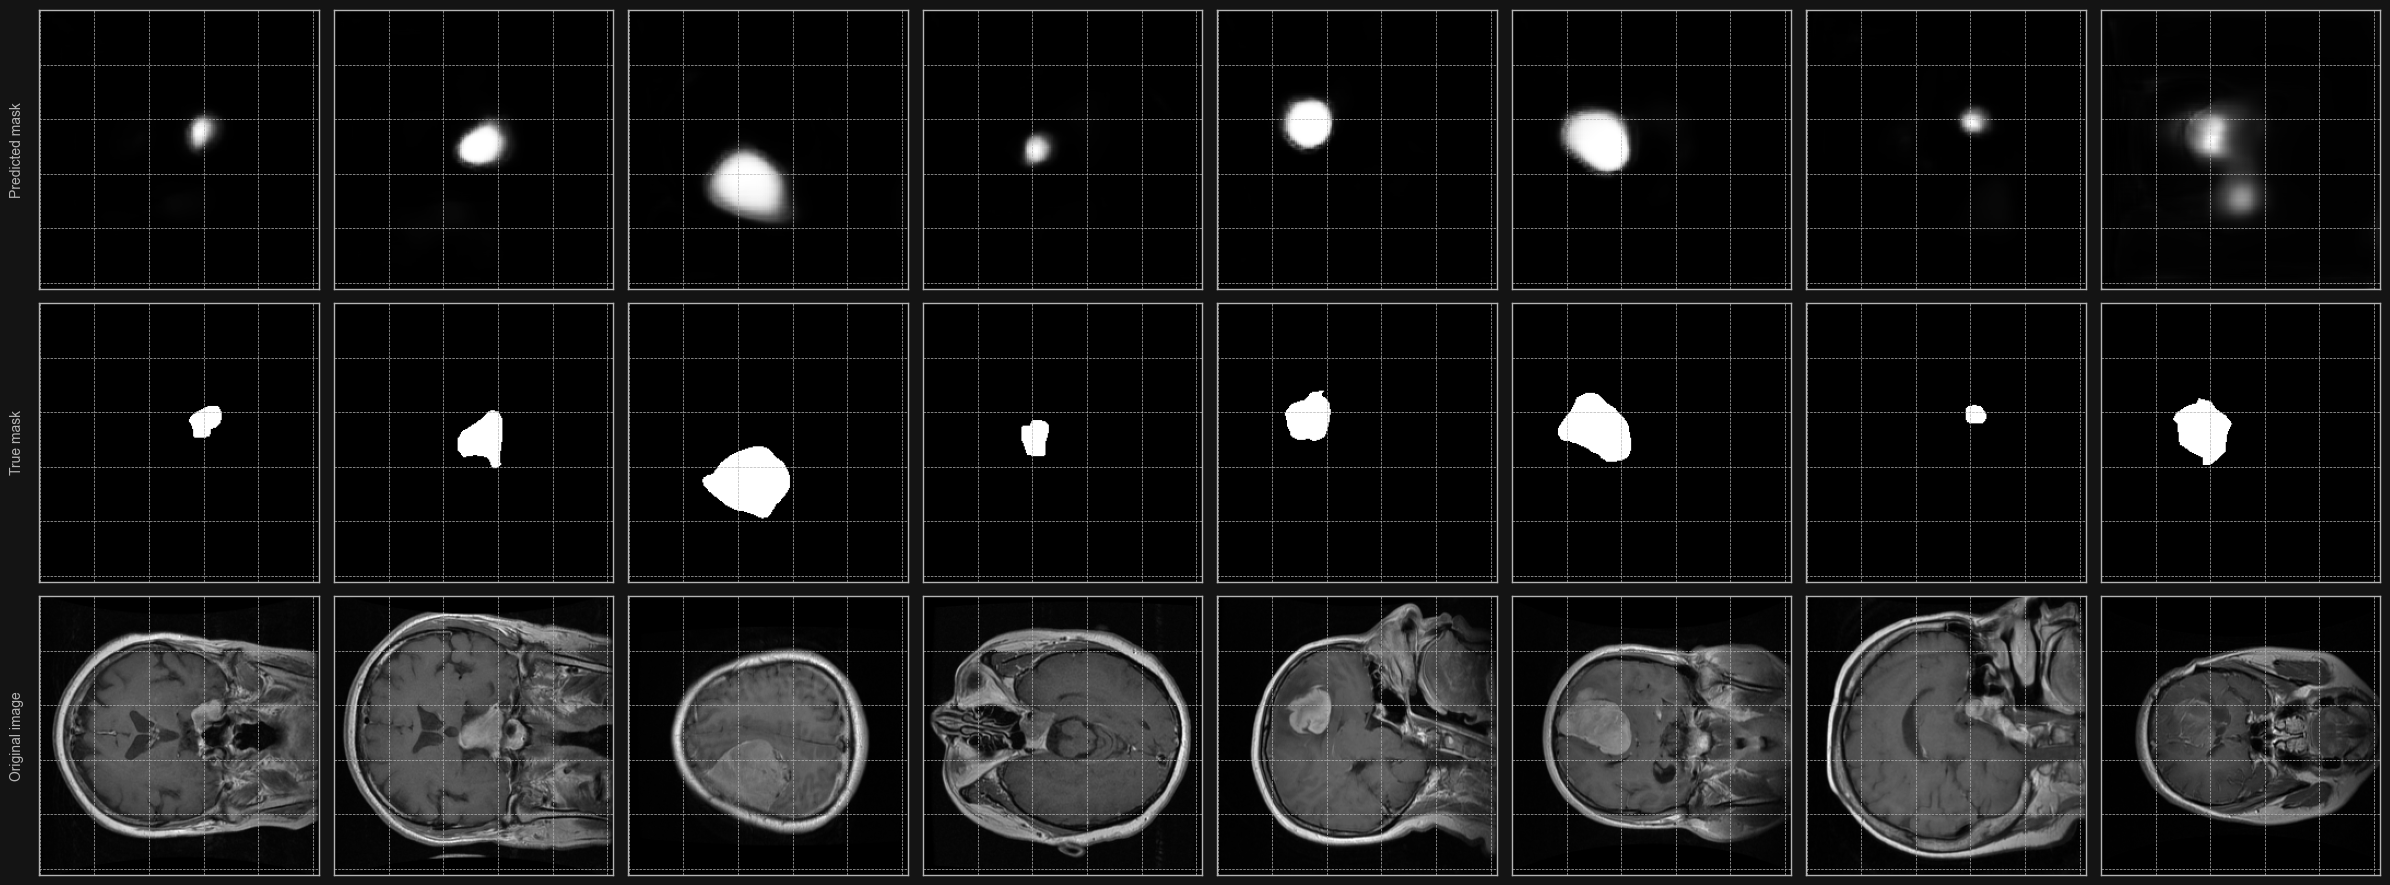

In [377]:
fig, axes = plt.subplots(nrows=3, ncols=8, figsize=(24, 9))
axes = axes.flatten()

for i in range(24):
    axes[i].set_xticklabels([])
    axes[i].set_yticklabels([])

for i in range(8):
    axes[i].imshow(y_pred[i], cmap='gray')
    axes[i+8].imshow(y_true[i], cmap='gray')
    axes[i+16].imshow(x_true[i], cmap='gray')

axes[0].set_ylabel('Predicted mask')
axes[8].set_ylabel('True mask')
axes[16].set_ylabel('Original image')

plt.tight_layout()

# V Conclusion
#### Tumor type classification
We ended up with decent F1 score of 95%. Despite this fact, model still have small problem with classifying _meningioma_ class, propably because of it's size.<br>
Note that the dataset itself is very good quality, it's balanced in terms of specific factors like: resolution, color range, object placement.<br><br>
#### Tumor location prediction
The training process takes way longer comparing to 1st model. However we can eventually increase the number of epochs to achieve better results.<br>
Honestly I don't think that's necessary.<br><br>
#### Significant improvement noticed after:
- Tweaking learning rate of the Adam optimizer
- Weighting classes
- Adding dropout layers for each convolution layer
<br>
instead of holding one dropout layer before output densing layers.
<br><br>
#### Ideas to improve:
- Preprocessing images with kmeans color clustering, didn't returned better results.
- Removing small images (head size), <br>
this meant to remove images where the number of black pixels exceeded a certain %.
<br><br>

Overall I think this is a good starting point to create some kind of application for brain MRI scans. It'd predict tumor type and it's location.<br><br>
#### Thanks for reading, I hope you enjoyed the analysis :] <br>
_Gracjan Pawłowski, 2024_